In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17592064765199560199, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11938526621995957394
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1927806976
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10558795696214125845
 physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11981645995128746845
 physical_device_desc: "device: XLA_GPU device"]

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
def load_all_cifar_data():
    folder_path = 'cifar-10-batches-py'
    data = []
    labels = []
    for i in range(1,6):
        batch = unpickle(f'{folder_path}/data_batch_{i}')
        data.append(batch[b'data'])
        labels.append(batch[b'labels'])
    
    return np.concatenate(tuple(data), axis=0), np.concatenate(tuple(labels), axis=0)

In [5]:
data, labels = load_all_cifar_data()

In [6]:
a = np.zeros((50000,10))
a[np.arange(50000), labels] = 1

labels = a
print(data.shape)
print(labels.shape)

(50000, 3072)
(50000, 10)


# Simple NN

In [7]:
model = tf.keras.Sequential()
from tensorflow.keras.layers import Dense
model.add(Dense(units=1024, activation='relu', input_dim=3072))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

W0923 22:59:15.988679 140406771664704 deprecation.py:506] From /home/nagianek/anaconda3/envs/ml-sandbox/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 3,805,450
Trainable params: 3,805,450
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(data, labels, validation_split=0.20, epochs=100, batch_size=64)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 5s 119us/sample - loss: 29.9388 - acc: 0.2289 - val_loss: 2.3637 - val_acc: 0.2850
Epoch 2/100
40000/40000 [==============================] - 3s 66us/sample - loss: 2.1262 - acc: 0.3046 - val_loss: 1.9516 - val_acc: 0.3154
Epoch 3/100
40000/40000 [==============================] - 3s 68us/sample - loss: 1.9325 - acc: 0.3381 - val_loss: 2.0335 - val_acc: 0.3119
Epoch 4/100
40000/40000 [==============================] - 3s 66us/sample - loss: 1.8486 - acc: 0.3538 - val_loss: 1.8422 - val_acc: 0.3680
Epoch 5/100
40000/40000 [==============================] - 3s 66us/sample - loss: 1.8303 - acc: 0.3623 - val_loss: 1.8054 - val_acc: 0.3656
Epoch 6/100
40000/40000 [==============================] - 3s 68us/sample - loss: 1.7950 - acc: 0.3732 - val_loss: 1.9511 - val_acc: 0.3273
Epoch 7/100
40000/40000 [==============================] - 3s 65us/sample - loss: 1.7846 - acc: 0.3708 - val

Epoch 59/100
40000/40000 [==============================] - 3s 71us/sample - loss: 1.3609 - acc: 0.5158 - val_loss: 1.6179 - val_acc: 0.4509
Epoch 60/100
40000/40000 [==============================] - 3s 79us/sample - loss: 1.3584 - acc: 0.5149 - val_loss: 1.5822 - val_acc: 0.4576
Epoch 61/100
40000/40000 [==============================] - 3s 79us/sample - loss: 1.3638 - acc: 0.5124 - val_loss: 1.6214 - val_acc: 0.4464
Epoch 62/100
40000/40000 [==============================] - 3s 79us/sample - loss: 1.3591 - acc: 0.5153 - val_loss: 1.5988 - val_acc: 0.4586
Epoch 63/100
40000/40000 [==============================] - 3s 79us/sample - loss: 1.3624 - acc: 0.5165 - val_loss: 1.5598 - val_acc: 0.4665
Epoch 64/100
40000/40000 [==============================] - 3s 79us/sample - loss: 1.3520 - acc: 0.5190 - val_loss: 1.6227 - val_acc: 0.4503
Epoch 65/100
40000/40000 [==============================] - 3s 76us/sample - loss: 1.3561 - acc: 0.5197 - val_loss: 1.5844 - val_acc: 0.4599
Epoch 66/100


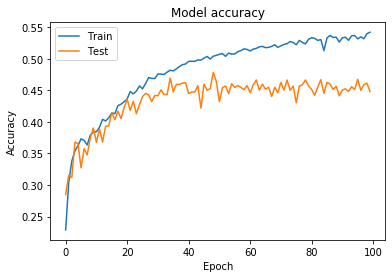

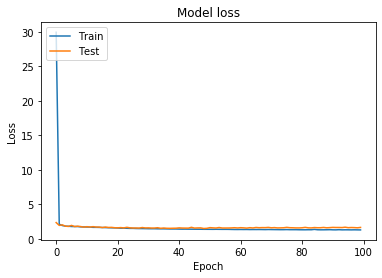

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
model.save('simple-nn-100-epochs.h5')

# CNN

In [7]:
def convert_data_for_cnn(data):
    num_entries_in_channel = int(data.shape[1] / 3)
    data_4d = np.zeros((50000,3,32,32))
    for i in range(50000):
        x = data[i]
        r_1d = x[0:num_entries_in_channel]
        g_1d = x[num_entries_in_channel:2*num_entries_in_channel]
        b_1d = x[num_entries_in_channel*2:]

        r_2d = np.reshape(r_1d, (32,32))
        g_2d = np.reshape(g_1d, (32,32))
        b_2d = np.reshape(b_1d, (32,32))
        
        image_3d = np.zeros((3,32,32))
        image_3d[0] = r_2d
        image_3d[1] = g_2d
        image_3d[2] = b_2d
                
        data_4d[i] = image_3d
    print(data_4d.shape)
    data_4d = np.swapaxes(data_4d,1,3)
    data_4d = np.swapaxes(data_4d, 1,2)
    return data_4d

In [8]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

W0923 23:33:33.794552 140267137079104 deprecation.py:506] From /home/nagianek/anaconda3/envs/ml-sandbox/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
from tensorflow.keras.optimizers import RMSprop

# initiate RMSprop optimizer
opt = RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [10]:
history = model.fit(convert_data_for_cnn(data), labels, validation_split=0.2, epochs=100, batch_size=64)

(50000, 3, 32, 32)
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 17s 419us/sample - loss: 3.0911 - acc: 0.2277 - val_loss: 1.6959 - val_acc: 0.3944
Epoch 2/100
40000/40000 [==============================] - 9s 216us/sample - loss: 1.6846 - acc: 0.3822 - val_loss: 1.5269 - val_acc: 0.4658
Epoch 3/100
40000/40000 [==============================] - 9s 213us/sample - loss: 1.5193 - acc: 0.4485 - val_loss: 1.3537 - val_acc: 0.5200
Epoch 4/100
40000/40000 [==============================] - 8s 211us/sample - loss: 1.4101 - acc: 0.4923 - val_loss: 1.2974 - val_acc: 0.5415
Epoch 5/100
40000/40000 [==============================] - 8s 208us/sample - loss: 1.3251 - acc: 0.5260 - val_loss: 1.2141 - val_acc: 0.5818
Epoch 6/100
40000/40000 [==============================] - 8s 209us/sample - loss: 1.2594 - acc: 0.5558 - val_loss: 1.1660 - val_acc: 0.5892
Epoch 7/100
40000/40000 [==============================] - 8s 205us/sample - loss: 1

40000/40000 [==============================] - 9s 225us/sample - loss: 0.7233 - acc: 0.7618 - val_loss: 0.7402 - val_acc: 0.7532
Epoch 59/100
40000/40000 [==============================] - 9s 228us/sample - loss: 0.7206 - acc: 0.7599 - val_loss: 0.7777 - val_acc: 0.7490
Epoch 60/100
40000/40000 [==============================] - 9s 231us/sample - loss: 0.7110 - acc: 0.7633 - val_loss: 0.7264 - val_acc: 0.7636
Epoch 61/100
40000/40000 [==============================] - 9s 219us/sample - loss: 0.7149 - acc: 0.7631 - val_loss: 0.7294 - val_acc: 0.7596
Epoch 62/100
40000/40000 [==============================] - 9s 222us/sample - loss: 0.7142 - acc: 0.7650 - val_loss: 0.7387 - val_acc: 0.7590
Epoch 63/100
40000/40000 [==============================] - 9s 229us/sample - loss: 0.7081 - acc: 0.7625 - val_loss: 0.7575 - val_acc: 0.7543
Epoch 64/100
40000/40000 [==============================] - 9s 221us/sample - loss: 0.7141 - acc: 0.7623 - val_loss: 0.7297 - val_acc: 0.7653
Epoch 65/100
40000/

In [11]:
model.save('simple-cnn-model-100-epoch.h5')

# CNN WITH DATA AUGMENTATION